# **Fake News**

### **libraries - load data - splitting**

In [1]:
#library(bnclassify)
#library(bnlearn)
#library(glmnet)
#library(bnviewer)
library(magrittr)
library(tidytext)
library(stringr)
library(syuzhet)
library(dplyr)
library(quanteda)
library(Matrix.utils)
#library(ggplot2)
library(SnowballC)
library(RColorBrewer)
#library(stopwords)
library(textstem)
library(tidyverse)
#library(caret)
fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 };
# Always load bnlearn after bnclassify, otherwise we get some objects masked when we need them


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Package version: 3.2.3
Unicode version: 14.0
ICU version: 71.1

Parallel computing: 8 of 8 threads used.

See https://quanteda.io for tutorials and examples.

Loading required package: Matrix

Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Attaching package: ‘koRpus’


The following objects are masked from ‘package:quanteda’:

    tokens, types


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ readr   2.1.2
✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.2.1     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_confli

# Loading the data and splitting

In [2]:
labelled_set <- read.csv('./fake_news_db/train.csv')

if(FALSE){unlabelled_set <- read.csv('./fake_news_db/test.csv')
    print(summary(unlabelled_set))
    anyNA(unlabelled_set)}

anyNA(labelled_set)

head(labelled_set)

[1] FALSE

,Labels,Text,Text_Tag
,<int>,<chr>,<chr>
1,1,Says the Annies List political group supports third-trimester abortions on demand.,abortion
2,2,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments"
3,3,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy
4,1,Health care reform legislation is likely to mandate free sex change surgeries.,health-care
5,2,The economic turnaround started at the end of my term.,"economy,jobs"
6,5,The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.,education


### Attribute description
The labels used for classifying the text are:

| Labels         | Values |
|----------------|:-----:|
| True           | 5     |
| Mostly True    | 3     |
| Half True      | 2     |
| Barely True    | 0     |
| False          | 1     |
| Not Known      | 4     |

<br>
The numerical values assigned to the labels are not sorted according to truthfulness in the training set. In our classification, we keep the same labels.


	Training set:


     Labels          Text             Text_Tag        
 Min.   :0.000   Length:8192        Length:8192       
 1st Qu.:1.000   Class :character   Class :character  
 Median :2.000   Mode  :character   Mode  :character  
 Mean   :2.333                                        
 3rd Qu.:3.000                                        
 Max.   :5.000                                        


	Test set:


     Labels          Text             Text_Tag        
 Min.   :0.000   Length:2048        Length:2048       
 1st Qu.:1.000   Class :character   Class :character  
 Median :2.000   Mode  :character   Mode  :character  
 Mean   :2.309                                        
 3rd Qu.:3.000                                        
 Max.   :5.000                                        

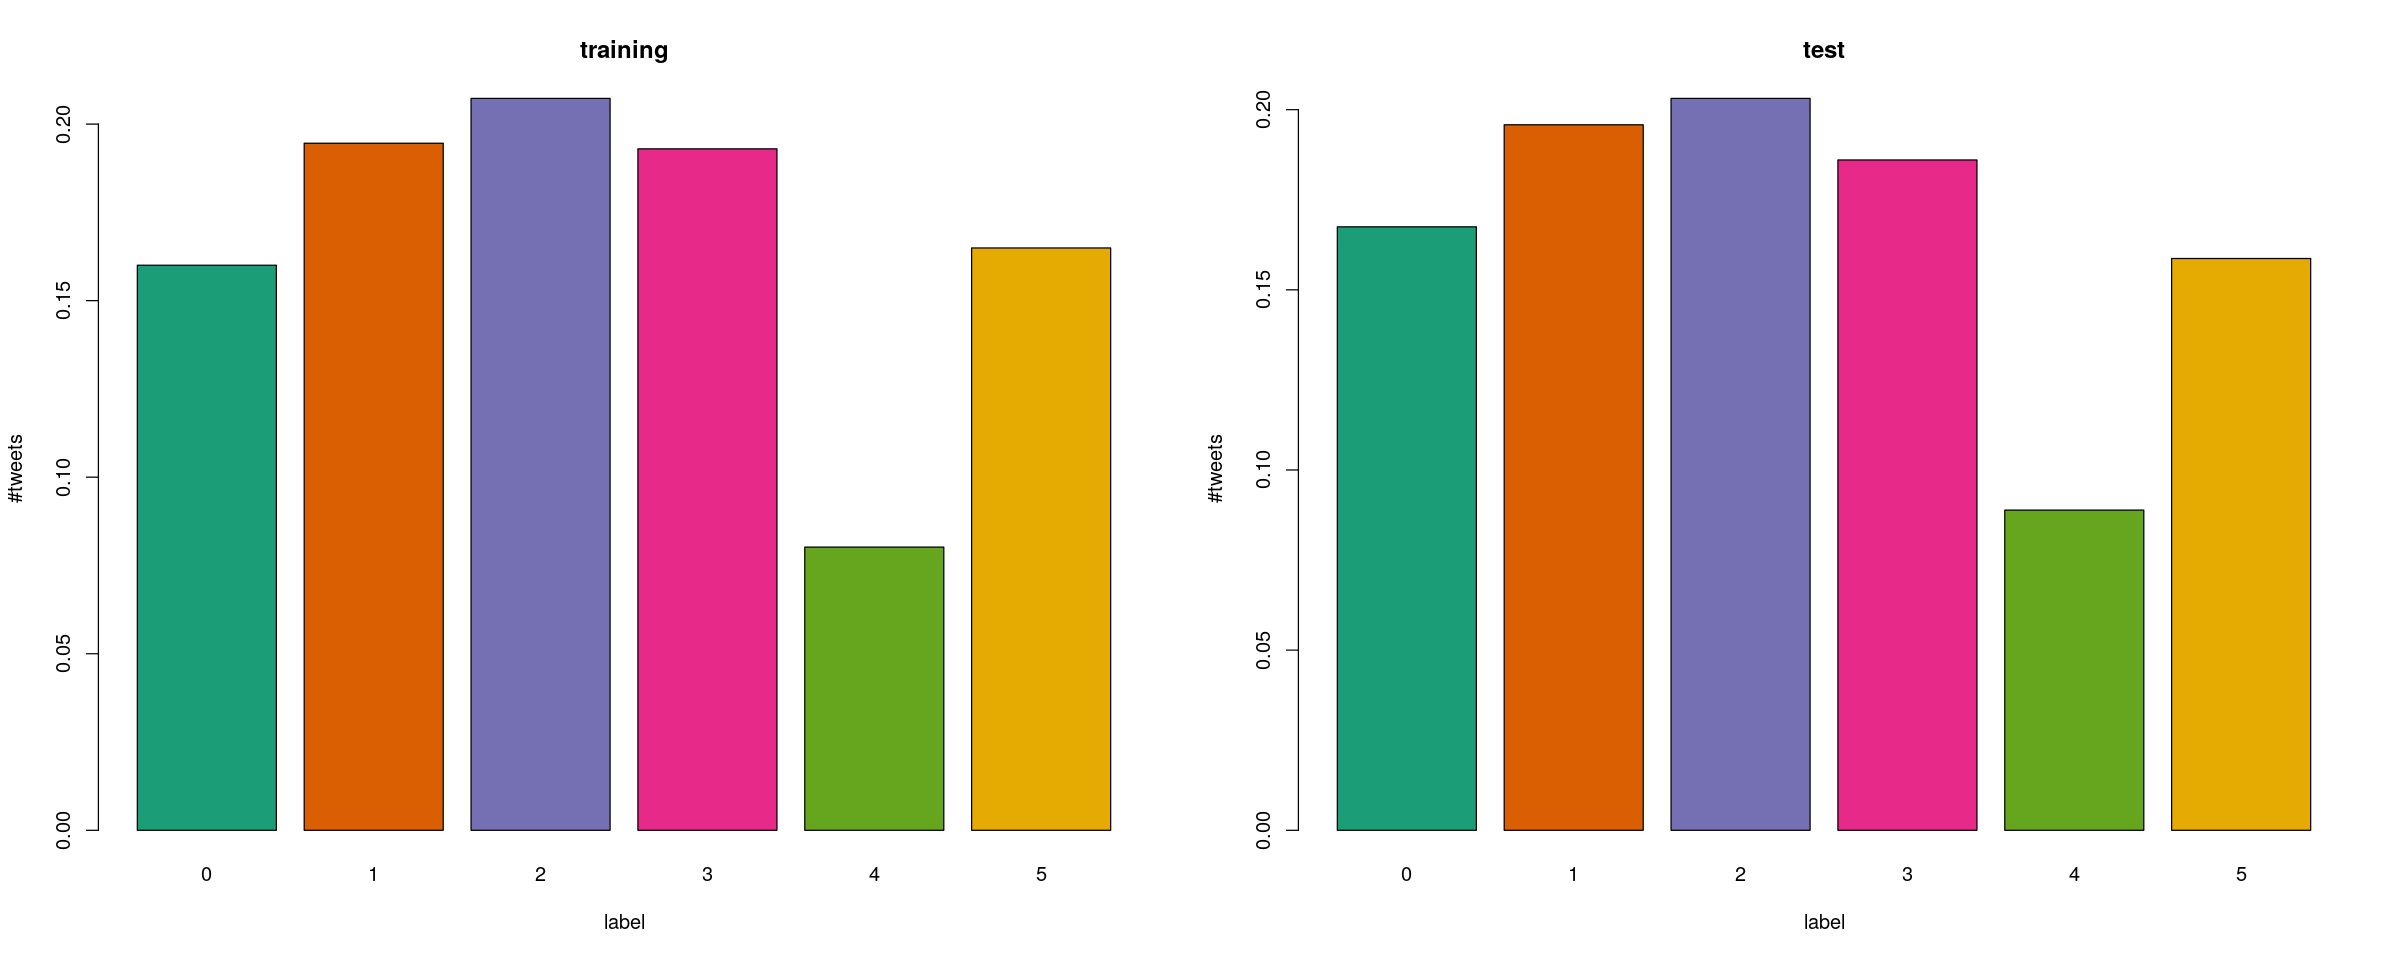

In [3]:
N <- length(labelled_set[,1])
train_fraction <- 0.8
limit <- N*train_fraction
train_set_raw <- labelled_set[1:limit,]
test_set_raw <- labelled_set[(1+limit):N,]
cat("\tTraining set:\n")
summary(train_set_raw)
cat("\n\tTest set:\n")
summary(test_set_raw)


fig(20, 8)
par(mfrow = c(1, 2))

dataset <- list(training = train_set_raw, test = test_set_raw)
for (i in 1:2) {
    label_freq <- summarise(group_by(dataset[[i]], Labels), counts = length(Labels))
    barplot(label_freq[[2]]/sum(label_freq[[2]]), names.arg = label_freq[[1]], col = brewer.pal(max(c(8, 2)), 'Dark2'), main = names(dataset)[i], xlab = 'label', ylab = '#tweets')
}

## Stemming

In [4]:
stemming <- function(raw_set){
    set <- unnest_tokens(
      tbl = raw_set,
      output = "words",
      input = "Text",
      token = "words",
      format = c("text", "man", "latex", "html", "xml"),
      to_lower = TRUE,
      drop = FALSE,
      collapse = NULL
    )
    set <- mutate(set, word_stem = wordStem(words, language="english"))
    set <- set %>% group_by(Text)  %>%
                        dplyr::summarise(doc_id = paste(word_stem, collapse = " "))
    set <- merge(raw_set, set, by='Text')
    return (set)}

In [5]:
train_set_stemmed <- stemming(train_set_raw)
head(train_set_stemmed)

test_set_stemmed <- stemming(test_set_raw)
head(test_set_stemmed)


,Text,Labels,Text_Tag,doc_id
,<chr>,<int>,<chr>,<chr>
1,... study after study has shown that the death penalty deters murders.,2,crime,studi after studi has shown that the death penalti deter murder
2,"...Over 30 years, federal spending on education has grown by 375 percent, but test scores remain flat.",3,"education,federal-budget",over 30 year feder spend on educ has grown by 375 percent but test score remain flat
3,"...some of those (tax increases) were either court-ordered, or they were voted on by the people and approved by the people for (such) things as roads.",2,taxes,some of those tax increas were either court order or they were vote on by the peopl and approv by the peopl for such thing as road
4,''I have received more contributions than any other candidate in the race Republican or Democrat.'',1,elections,i have receiv more contribut than ani other candid in the race republican or democrat
5,(After the auto bailout) General Motors is back on top as the worlds No. 1 automaker.,2,"economy,jobs",after the auto bailout general motor is back on top as the world no 1 automak
6,"(Big banks) have invested over $300,000 in (Joe Heck), and Heck has sponsored $44 million dollars in tax breaks for banks.",0,campaign-finance,"big bank have invest over 300,000 in joe heck and heck has sponsor 44 million dollar in tax break for bank"


,Text,Labels,Text_Tag,doc_id
,<chr>,<int>,<chr>,<chr>
1,"(Bill) McCollum also voted for numerous amendments to weaken the legislation, even voting to make trains less accessible to those in wheelchairs.",5,disability,bill mccollum also vote for numer amend to weaken the legisl even vote to make train less access to those in wheelchair
2,(I) helped to invent a system that saved over a billion dollars on welfare.,5,"candidates-biography,economy,families,federal-budget,government-efficiency,poverty",i help to invent a system that save over a billion dollar on welfar
3,"(Mary) Burkes company, Trek Bicycles, makes 99% of their bikes overseas.",3,"labor,workers",mari burk compani trek bicycl make 99 of their bike oversea
4,(Pete) Sessions has held at least two fundraisers at adult-themed clubs and made no apologies.,2,ethics,pete session has held at least two fundrais at adult theme club and made no apolog
5,"(President Barack Obama gave) half a billion in taxpayer money to help his friends at Solyndra, a business the White House knew was on the path to bankruptcy.",0,"campaign-finance,corporations,energy,ethics,jobs,stimulus",presid barack obama gave half a billion in taxpay money to help his friend at solyndra a busi the white hous knew was on the path to bankruptci
6,(Rep. Bob Goodlattes) balanced budgetamendment does not require a balanced budget.,0,"deficit,federal-budget",rep bob goodlatt balanc budgetamend doe not requir a balanc budget


## Feature generation

In [6]:
feature_generation <- function(set, emotion = TRUE, punctuation = TRUE, ngrams = TRUE, highest_gram, minimum_frequencies, toocommon){
    
    if(emotion){
        detected_emotions <- get_nrc_sentiment(set$Text, cl = NULL, language = "english", lowercase = TRUE)
        set <- cbind(set, detected_emotions)
    }
    
    if(punctuation){
        set$length <- nchar(set$Text)
        set$esclam_mark <- str_count(set$Text, "!")
        set$commas <- str_count(set$Text, ",")
        set$two_points <- str_count(set$Text, ":")
        set$semicolon <- str_count(set$Text, ";")        
    }
    
    if(ngrams){
        set <- make_extended_dfm(set, highest_gram, minimum_frequencies, toocommon)
    }
    
    set[is.na(set)] <- 0

    return(set)}

#-----------------------------------------------------------------------------------------------------------------------------------------

gram_sparse_create <- function(dataset, rarity, toocommon){
    tidy_tweets1 <- unnest_tokens(dataset, "term", "doc_id", token = "words", drop = FALSE)
    tidy_tweets1 <- tidy_tweets1 %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_common))
    too_rare <- (tidy_tweets1 %>% dplyr::count(term) %>% filter(!(term %in% too_common)) %>% filter(n < rarity))$term
    tidy_tweets1 <- tidy_tweets1 %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_common)) %>% filter(!(term %in% too_rare))
    cast_tweets1 <- tidy_tweets1 %>% cast_dfm(doc_id, term, n) %>% convert(to = "data.frame")
    return(cast_tweets1)
}

#-----------------------------------------------------------------------------------------------------------------------------------------

ngram_sparse_create <- function(dataset, nn, rarity){
    tidy_tweetsn <- unnest_tokens(dataset, "term", "doc_id", token = "ngrams", n = nn, drop = FALSE)
    tidy_tweetsn <- tidy_tweetsn %>% dplyr::count(Labels, doc_id, term) #%>% filter(!(term %in% too_common))
    too_raren <- (tidy_tweetsn %>% dplyr::count(term) %>% filter(n < rarity))$term #%>% filter(!(term %in% too_common)) 
    tidy_tweetsn <- tidy_tweetsn %>% dplyr::count(Labels, doc_id, term) %>% filter(!(term %in% too_raren)) #%>% filter(!(term %in% too_common))
    cast_tweetsn <- tidy_tweetsn %>% cast_dfm(doc_id, term, n) %>% convert(to = "data.frame") 
    return(cast_tweetsn)
}

#-----------------------------------------------------------------------------------------------------------------------------------------

make_extended_dfm <- function(dframe, highest_gram, minimum_frequencies, toocommon){
    dfm <- merge(x = dframe, 
                y = gram_sparse_create(dframe, minimum_frequencies[1], toocommon),
                by = "doc_id", 
                all = TRUE)
    for (i in 2:highest_gram) {
        dfm <- merge(x = dfm, 
                     y = ngram_sparse_create(dframe, i, minimum_frequencies[i]),
                     by = "doc_id", 
                     all = TRUE)
    }
    return(dfm)
 }

In [23]:
too_common <- c("in", "the", "of", "to", "a", "and", "they", "or", "for", "that", "says", "we", 
             "more", "at", "be", "about", "will", "one", "an", "his", "you", "their", "is", 
             "on", "has", "have", "are", "was", "by", "it", "from", "with", "as", "not", "our", 
             "I", "this", "he", "been", "NA")


train_set <- feature_generation(train_set_stemmed, emotion = FALSE, punctuation = FALSE, ngrams = TRUE, highest_gram = 1, minimum_frequencies = c(50, 10, 5, 5), toocommon = toocommon)
test_set <- feature_generation(test_set_stemmed, emotion = FALSE, punctuation = FALSE, ngrams = TRUE, highest_gram = 1, minimum_frequencies = c(50, 10, 5, 5), toocommon = toocommon)

train_set <- train_set[!is.na(colnames(train_set))]
test_set <- test_set[!is.na(colnames(test_set))]

head(train_set)
head(test_set)

,doc_id,Text,Labels,Text_Tag,1.x,3.x,colleg.x,go.x,high.x,kid.x,⋯,sign.y,build.y,polit.y,teacher.y,paul.y,combin.y,oregon.y,doubl.y,earn.y,5.y
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1 3 of our kid drop out of high school cannot go to colleg or start a career,"1/3 of our kids drop out (of high school), cannot go to college or start a career.",0,"corrections-and-updates,education",1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
2,1 percent of candid that the nation rifl associ endors in 2012 won,1 percent of candidates that (the National Rifle Association) endorsed in 2012 won.,1,"campaign-finance,guns,pundits",1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,1.53 million job are at risk from potenti defens cut,1.53 million jobs are at risk (from potential defense cuts).,3,"deficit,jobs,message-machine-2012,military",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,10 cent on thedollar from the clinton foundat goe to charit caus,10 cents on thedollar from the Clinton Foundation goes to charitable causes.,1,candidates-biography,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,100 percent of the crime is commit in estim by about 15 percent of the popul,"100 percent of the crime is committed, in estimate, by about 15 percent of the population.",4,"corrections-and-updates,crime,criminal-justice,population",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,"100,000 in stimulus fund were use for a martini bar and brazilian steakhous","$100,000 in stimulus funds (were) used for a Martini Bar and Brazilian Steakhouse.",3,stimulus,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,doc_id,Text,Labels,Text_Tag,job.x,when.x,feder.x,percent.x,were.x,govern.x,⋯,not,we,this,say.y,i.y,clinton.y,out.y,rais.y,dollar.y,had.y
,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1 in 4 rhode island under the age of 65 doe not have health insur,1 in 4 Rhode Islanders under the age of 65 does not have health insurance.,2,health-care,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
2,1.3 million peopl in america make their live off ebay,1.3-million people in America make their living off eBay.,1,economy,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,"15 year ago cancer drug cost an averag of 10,000 a year now it 10,000 a month","15 years ago, cancer drugs cost an average of $10,000 a year. Now its $10,000 a month.",3,health-care,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,"150,000 oil spill claim have been file by floridian but onli 40 percent of them have been paid","150,000 (oil spill) claims have been filed by Floridians, but only 40 percent of them have been paid.",5,oil-spill,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,2.4 million of the nih dollar was spent on origami condom,$2.4 million of the NIH dollars was spent on origami condoms.,3,"ebola,public-health",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
6,20 million peopl could lose their current coverag includ our senior citizen who are on medicar,20 million people could lose their current coverage including our senior citizens who are on Medicare.,4,"health-care,medicare,message-machine-2012,10-news-tampa-bay",0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Classifier

In [24]:
classifier_assemble <- function(dfm){
    df_count <- aggregate(.~Labels, 
                      data = dfm[, -which(names(dfm) == "Text" | names(dfm) == "Text_Tag" | names(dfm) == "doc_id")], 
                      FUN = sum)
    
    df_count <- df_count + 1
    df_count$Labels <- df_count$Labels - 1
    label.density <- dfm %>% group_by(Labels) %>% summarize(counts = n_distinct(doc_id))
    label.density$counts <- label.density$counts/sum(label.density$counts)
    df_count$label.density <- label.density$counts
    df_count$total.num <- rowSums(df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" )]) 
    
    df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" | names(df_count) == "total.num")] <- df_count[, -which(names(df_count) == "Labels" | names(df_count) == "label.density" | names(df_count) == "total.num")]/df_count$total.num #loop on 5 indexes

    df_count %>% select(-matches('^$'))
    return(df_count)
}

In [25]:
df_count <- classifier_assemble(train_set)
df_count

Labels,1.x,3.x,colleg.x,go.x,high.x,kid.x,out.x,school.x,start.x,⋯,polit.y,teacher.y,paul.y,combin.y,oregon.y,doubl.y,earn.y,5.y,label.density,total.num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.0007959671,0.0002358421,0.0004716842,0.0013266118,0.0005011645,0.0002063618,0.001680375,0.0011497303,0.0002063618,⋯,0.0001179211,0.0002063618,0.0002653224,0.0002358421,0.0002358421,0.0002653224,0.0002358421,0.0001768816,0.16022977,33921
1,0.0006763260,0.0002861379,0.0002861379,0.0013006269,0.0003641755,0.0002601254,0.001586765,0.0008844263,0.0002341128,⋯,0.0004682257,0.0003901881,0.0003381630,0.0002861379,0.0004162006,0.0002601254,0.0001300627,0.0003641755,0.19396236,38443
2,0.0008840951,0.0003757404,0.0005525595,0.0008619928,0.0005304571,0.0003094333,0.001414552,0.0014145522,0.0005083547,⋯,0.0002652285,0.0003978428,0.0003536381,0.0004199452,0.0001768190,0.0003978428,0.0002210238,0.0003536381,0.20728428,45244
3,0.0011540126,0.0003606289,0.0006491321,0.0009376352,0.0005289224,0.0002885031,0.001466558,0.0011299707,0.0004087128,⋯,0.0002644612,0.0002644612,0.0001442516,0.0001682935,0.0004327547,0.0003365870,0.0005529644,0.0002163774,0.19322904,41594
4,0.0005438395,0.0003021331,0.0003021331,0.0014502387,0.0003625597,0.0001812798,0.001148106,0.0013293855,0.0003021331,⋯,0.0002417064,0.0001208532,0.0002417064,0.0001208532,0.0001812798,0.0003625597,0.0003021331,0.0001812798,0.08029822,16549
5,0.0011241137,0.0002305874,0.0006629388,0.0008358794,0.0004899983,0.0003170577,0.001268231,0.0011241137,0.0003747046,⋯,0.0003170577,0.0002594108,0.0003170577,0.0005476451,0.0004323514,0.0004899983,0.0002305874,0.0004611748,0.16499633,34694


In [26]:
# updated
predict <- function(df_count, X_set){
    df.one <- df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]
    df.one.func <- function(x){
        dim <- dim(as.matrix(x[which(x != 0)]))[1]
        #print(dim)
        if(dim > 2) {
            a <- t(as.matrix(x[which(x != 0)]))
            b <- (as.matrix(df.one[,which(x != 0)]))
            power.func  <- function(y){return(y <- y**a[,-1])} #each prob to the power of repeatence
            c <- as.matrix(t(apply(b[,-1] ,1, power.func)))  #applyting the power function
            c <- cbind(c, df_count$label.density)

            prob.finder <- function(x){return(prod(x))}  #a function which stores the product of all probs.  
            df.final <- cbind(c, Label.Prob = apply(c, 1, prob.finder)) #dataframe of porbs for each sample
            df.final <- cbind(df.final, Label = 0:5) #dataframe of porbs for each sample 
            df.final <- data.frame(df.final)

            predicted_label  <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))] #%>% print()
            return(predicted_label)
        } else {
            return(NA)
        }
    }
    predicted_label = t(apply(train_set[,-which(names(X_set) == "doc_id" | names(X_set) == "Text" | names(X_set) == "Text_Tag")], 1, df.one.func))
    #print("done")
    #X_set_all<- cbind(X_set, predicted_label)
    return(data.frame(t(predicted_label)))}



In [27]:
Y_train_pred <- predict(df_count, train_set)
Y_train_pred <- as.integer(as.character(Y_train_pred$t.predicted_label)) %>% replace_na(7)
Y_train <- as.integer(as.character(train_set$Labels))

Warning message in replace_na(., 7):
“NAs introduced by coercion”


In [28]:
Y_test_pred <- predict(df_count, test_set)
Y_test_pred <- as.integer(as.character(Y_test_pred$t.predicted_label)) %>% replace_na(7)
Y_test <- as.integer(as.character(test_set$Labels))

Warning message in replace_na(., 7):
“NAs introduced by coercion”


In [29]:
score <- function(Y, Y_pred){length(Y[Y == Y_pred])/length(Y)}
train_score <- score(Y_train, Y_train_pred) %>% print()
test_score <- score(Y_test, Y_test_pred) %>% print()

[1] 0.4176025
[1] 0.7041016


# **old things**

In [ ]:
# first
predict <- function(df_count, X_set){
    df.one <- df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]
    print(dim(df.one))
    df.one.func <- function(x){
        a <- x[which(x != 0)]
        b <- df.one[,which(x != 0)]
        print(dim(b))
        power.func  <- function(y){return(y <- y**as.matrix(a[,-1]))} #each prob to the power of repeatence
        c <- t(apply(as.matrix(b[,-1]) ,1, power.func))  #applyting the power function
        c <- cbind(c, df_count$label.density)

        prob.finder <- function(x){return(prod(x))}  #a function which stores the product of all probs.  
        df.final <<- cbind(c, Label.Prob = apply(c, 1, prob.finder)) #dataframe of porbs for each sample
        df.final <<- cbind(df.final, Label = 0:5) #dataframe of porbs for each sample 
        df.final <<- data.frame(df.final)

        predicted_label  <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))] 
        return(predicted_label)}#the final predicted label
     
    X_set_all<- cbind(X_set, predicted_label = apply(X_set[1,-which(names(X_set) == "doc_id" | names(X_set) == "Text" | names(X_set) == "Text_Tag")], 1, df.one.func))
    return(X_set_all)}

In [ ]:
# single
df.one <- df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]
df.one.func <- function(x){
    a <- as.matrix(x[which(x != 0)])
    b <- (as.matrix(df.one[,which(x != 0)]))
    print(dim(b))
    print(dim(a))
    power.func  <- function(y){return(y <- y**a[,-1])} #each prob to the power of repeatence
    c <- as.matrix(t(apply(b[,-1] ,1, power.func)))  #applyting the power function
    print(dim(c))
    print(c)
    c <- cbind(c, df_count$label.density)

    prob.finder <- function(x){return(prod(x))}  #a function which stores the product of all probs.  
    df.final <- cbind(c, Label.Prob = apply(c, 1, prob.finder)) #dataframe of porbs for each sample
    print((df.final))
    df.final <- cbind(df.final, Label = 0:5) #dataframe of porbs for each sample 
    df.final <- data.frame(df.final)

    predicted_label  <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))] %>% print()
    return(predicted_label)}#the final predicted label
df.one.func(train_set[10,-which(names(train_set) == "doc_id" | names(train_set) == "Text" | names(train_set) == "Text_Tag")])

In [ ]:
# parallel
df.one <- df_count[,-which(names(df_count) == "total.num" | names(df_count) == "label.density")]
df.one.func <- function(x){
    a <- t(as.matrix(x[which(x != 0)]))
    b <- (as.matrix(df.one[,which(x != 0)]))
    print(dim(b))
    print(dim(a))
    power.func  <- function(y){return(y <- y**a[,-1])} #each prob to the power of repeatence
    c <- as.matrix(t(apply(b[,-1] ,1, power.func)))  #applyting the power function
    print(dim(c))
    print(c)
    c <- cbind(c, df_count$label.density)

    prob.finder <- function(x){return(prod(x))}  #a function which stores the product of all probs.  
    df.final <- cbind(c, Label.Prob = apply(c, 1, prob.finder)) #dataframe of porbs for each sample
    print((df.final))
    df.final <- cbind(df.final, Label = 0:5) #dataframe of porbs for each sample 
    df.final <- data.frame(df.final)

    predicted_label  <- df.final$Label[which(df.final$Label.Prob == max(df.final$Label.Prob))] %>% print()
    return(predicted_label)}#the final predicted label
apply(train_set[,-which(names(train_set) == "doc_id" | names(train_set) == "Text" | names(train_set) == "Text_Tag")], 1, df.one.func)